# Preprocess Pickle

In this notebook we examine the JSON file from RecipeBox, perform statistics on the dataset, clean it up, and save the cleaned dataset to disk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pathlib
import os
import re

from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Download dataset

In [ ]:
CACHE_DIR = "./drive/Shared drives/Capstone/tmp"
pathlib.Path(CACHE_DIR).mkdir(exist_ok=True)

In [ ]:
data_file = "recipes_raw.zip"
data_origin = "https://storage.googleapis.com/recipe-box/recipes_raw.zip"

data_file = tf.keras.utils.get_file(
    fname=data_file,
    origin=data_origin,
    cache_dir=CACHE_DIR,
    extract=True,
    archive_format='zip'
)

In [ ]:
data_srcs = ['ar', 'epi', 'fn'] # Allrecipes, Epicurious, Food Network
data_files = map(lambda fname: f"{CACHE_DIR}/datasets/recipes_raw_nosource_{fname}.json", data_srcs)
dfs = [pd.read_json(f).T for f in list(data_files)]

In [ ]:
recipes = pd.concat(dfs) \
    .reset_index(drop=True) \
    .drop(['picture_link'], axis=1)

# Process data

In [ ]:
recipes['ingredients']

0         [4 skinless, boneless chicken breast halves AD...
1         [2 (10.75 ounce) cans condensed cream of mushr...
2         [1/2 cup packed brown sugar ADVERTISEMENT, 1/2...
3         [1 cup butter, softened ADVERTISEMENT, 1 cup w...
4         [8 ounces whole wheat rotini pasta ADVERTISEME...
                                ...                        
125159    [4 ears fresh corn, 2 heads Belgian endive, 2 ...
125160    [4 large plum tomatoes, Salt and sugar, 1 1/2 ...
125161    [3 tablespoons olive oil, 2 tablespoons unsalt...
125162    [8 ounces butter, 8 ounces bittersweet chocola...
125163    [3 (10.5-ounce) cans restaurant-style condense...
Name: ingredients, Length: 125164, dtype: object

In [ ]:
# Drop rows with NA values
recipes = recipes.dropna()

In [ ]:
def format_title(title):
    # # NOTE: Training GPT-2 on data without Roman Numerals did worse
    # # Remove Roman numerals found in titles (list created by manually checking through the recipes)
    # for numeral in ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII']:
    #     if title.endswith(f' {numeral}'):
    #         return title[:title.rfind(' ')]

    return title
    
def format_ingredients(ingredients):
    ingredients = [i.replace('ADVERTISEMENT', '').strip() for i in ingredients]
    ingredients = list(filter(lambda x: x != "", ingredients))
    ingredients = ''.join(map(lambda i: f"• {i}\n", ingredients))

    return ingredients

def format_instructions(instructions):
    instructions = instructions.split('\n')
    instructions = list(filter(lambda x: x != "", instructions))
    instructions = ''.join(map(lambda i: f"‣ {i}\n", instructions))

    return instructions

In [ ]:
recipes['title'] = recipes['title'].apply(format_title)
recipes['ingredients'] = recipes['ingredients'].apply(format_ingredients)
recipes['instructions'] = recipes['instructions'].apply(format_instructions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# Filter out long recipes
recipe_lengths = recipes['instructions'].map(len)
recipe_maxlen = int(np.percentile(recipe_lengths, 85)) # Set maximum length at 85th percentile (TODO: might hardcode this)
filtered_recipes = recipes[recipes['instructions'].str.len() < recipe_maxlen]

print(f"Removed {len(recipes) - len(filtered_recipes)} recipes. Kept {len(filtered_recipes)} recipes.")

Removed 18682 recipes. Kept 105791 recipes.


# Save dataset to disk

In [ ]:
recipes

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"• 4 skinless, boneless chicken breast halves\n...","‣ Place the chicken, butter, soup, and onion i..."
1,Awesome Slow Cooker Pot Roast,• 2 (10.75 ounce) cans condensed cream of mush...,"‣ In a slow cooker, mix cream of mushroom soup..."
2,Brown Sugar Meatloaf,• 1/2 cup packed brown sugar\n• 1/2 cup ketchu...,‣ Preheat oven to 350 degrees F (175 degrees C...
3,Best Chocolate Chip Cookies,"• 1 cup butter, softened\n• 1 cup white sugar\...",‣ Preheat oven to 350 degrees F (175 degrees C...
4,Homemade Mac and Cheese Casserole,• 8 ounces whole wheat rotini pasta\n• 3 cups ...,‣ Preheat oven to 350 degrees F. Line a 2-quar...
...,...,...,...
125159,Summer Corn Salad,• 4 ears fresh corn\n• 2 heads Belgian endive\...,‣ Watch how to make this recipe.\n‣ Preheat a ...
125160,Zucchini Stuffed Tomatoes,• 4 large plum tomatoes\n• Salt and sugar\n• 1...,‣ Preheat the broiler. Cut the tomatoes in 1/2...
125161,Pepper Pasta Quick Cook,• 3 tablespoons olive oil\n• 2 tablespoons uns...,‣ Heat the oil and butter in a large skillet o...
125162,Chocolate Cake with Armagnac Ice Cream,• 8 ounces butter\n• 8 ounces bittersweet choc...,‣ Preheat oven to 350 degrees. On the top half...


In [ ]:
dataset_path = os.path.join(CACHE_DIR, 'recipes.pkl')
filtered_recipes.to_pickle(dataset_path) 

# Statistics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
recipes

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"• 4 skinless, boneless chicken breast halves\n...","‣ Place the chicken, butter, soup, and onion i..."
1,Awesome Slow Cooker Pot Roast,• 2 (10.75 ounce) cans condensed cream of mush...,"‣ In a slow cooker, mix cream of mushroom soup..."
2,Brown Sugar Meatloaf,• 1/2 cup packed brown sugar\n• 1/2 cup ketchu...,‣ Preheat oven to 350 degrees F (175 degrees C...
3,Best Chocolate Chip Cookies,"• 1 cup butter, softened\n• 1 cup white sugar\...",‣ Preheat oven to 350 degrees F (175 degrees C...
4,Homemade Mac and Cheese Casserole,• 8 ounces whole wheat rotini pasta\n• 3 cups ...,‣ Preheat oven to 350 degrees F. Line a 2-quar...
...,...,...,...
125159,Summer Corn Salad,• 4 ears fresh corn\n• 2 heads Belgian endive\...,‣ Watch how to make this recipe.\n‣ Preheat a ...
125160,Zucchini Stuffed Tomatoes,• 4 large plum tomatoes\n• Salt and sugar\n• 1...,‣ Preheat the broiler. Cut the tomatoes in 1/2...
125161,Pepper Pasta Quick Cook,• 3 tablespoons olive oil\n• 2 tablespoons uns...,‣ Heat the oil and butter in a large skillet o...
125162,Chocolate Cake with Armagnac Ice Cream,• 8 ounces butter\n• 8 ounces bittersweet choc...,‣ Preheat oven to 350 degrees. On the top half...


In [ ]:
recipes['instr_len'] = recipes['instructions'].map(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
recipes['ingr_len'] = recipes['ingredients'].map(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
recipes['title_len'] = recipes['title'].map(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
np.mean(recipes['title_len'])

28.302876929133227

In [ ]:
np.argmin([len(title) for title in recipes['title']])

65843

In [ ]:
[title for title in recipes['title']][65843]

'QA'

Text(0.5, 0, 'Instruction length (characters)')

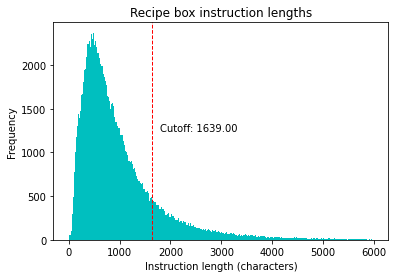

In [ ]:
cutoff = recipes['instr_len'].quantile(q=0.85)
plt.title("Recipe box instruction lengths")
recipes['instr_len'].plot(kind='hist',
                          bins=np.arange(0, 6000, 20),
                          color='c')
plt.axvline(cutoff,
            color='r',
            linestyle='dashed',
            linewidth=1)
bottom, top = plt.ylim()
plt.text(cutoff * 1.1,
         top * 0.5,
         'Cutoff: {:.2f}'.format(cutoff))
plt.xlabel("Instruction length (characters)")

In [ ]:
recipes['instr_len'].quantile(q=0.85)

1639.0

In [ ]:
dataset_path = os.path.join(CACHE_DIR, 'emoji_text_recipes.pkl')
if not os.path.exists(dataset_path):
    raise SystemExit("Run preprocess_rnn_word.ipynb to generate data file before continuing")
else:
    df_recipes = pd.read_pickle(dataset_path)

In [ ]:
recipes

,title,ingredients,instructions,instr_len,ingr_len,title_len
0,Slow Cooker Chicken and Dumplings,"• 4 skinless, boneless chicken breast halves\n...","‣ Place the chicken, butter, soup, and onion i...",279,216,33
1,Awesome Slow Cooker Pot Roast,• 2 (10.75 ounce) cans condensed cream of mush...,"‣ In a slow cooker, mix cream of mushroom soup...",214,141,29
2,Brown Sugar Meatloaf,• 1/2 cup packed brown sugar\n• 1/2 cup ketchu...,‣ Preheat oven to 350 degrees F (175 degrees C...,363,263,20
3,Best Chocolate Chip Cookies,"• 1 cup butter, softened\n• 1 cup white sugar\...",‣ Preheat oven to 350 degrees F (175 degrees C...,418,266,27
4,Homemade Mac and Cheese Casserole,• 8 ounces whole wheat rotini pasta\n• 3 cups ...,‣ Preheat oven to 350 degrees F. Line a 2-quar...,1015,441,33
...,...,...,...,...,...,...
125159,Summer Corn Salad,• 4 ears fresh corn\n• 2 heads Belgian endive\...,‣ Watch how to make this recipe.\n‣ Preheat a ...,763,303,17
125160,Zucchini Stuffed Tomatoes,• 4 large plum tomatoes\n• Salt and sugar\n• 1...,‣ Preheat the broiler. Cut the tomatoes in 1/2...,1174,217,25
125161,Pepper Pasta Quick Cook,• 3 tablespoons olive oil\n• 2 tablespoons uns...,‣ Heat the oil and butter in a large skillet o...,2551,738,23
125162,Chocolate Cake with Armagnac Ice Cream,• 8 ounces butter\n• 8 ounces bittersweet choc...,‣ Preheat oven to 350 degrees. On the top half...,1503,158,38


In [ ]:
df_ready_recipe_dataset_path = os.path.join(CACHE_DIR, 'ready_cleaned_recipes_20210531_ext.pkl')
if not os.path.exists(df_ready_recipe_dataset_path):
    raise SystemExit("Run preprocess_checklist.ipynb to generate data file before continuing")
else:
    df_recipes = pd.read_pickle(df_ready_recipe_dataset_path)

In [ ]:
recipe_instrs = df_recipes["raw_instructions"]
recipe_ingrs = df_recipes["ingredients"]
recipe_titles = df_recipes["title"]
recipes = df_recipes["recipe"]

In [ ]:
recipes

0         🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...
1         🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....
2         🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...
3         🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...
4         🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...
                                ...                        
125158    🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...
125159    🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...
125160    🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...
125162    🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...
125163    🍴 Crabby Bisque\n\n🥑\n• 3 (10.5-ounce) cans re...
Name: recipe, Length: 105789, dtype: object

In [ ]:
to_exclude = '#$&*/<=>@[\\]^_`{|}~\t'
to_tokenize = '.,:;!?"-+()%\'\n'

def separate_punct(text):
    return re.sub(r'(['+to_tokenize+'])', r' \1 ', text)

recipes = recipes.progress_apply(lambda recipe: separate_punct(recipe))
recipe_instrs = recipes.progress_apply(lambda recipe: separate_punct(recipe))
recipe_titles = recipes.progress_apply(lambda recipe: separate_punct(recipe))


100%|██████████| 105789/105789 [00:06<00:00, 15223.64it/s]

100%|██████████| 105789/105789 [00:07<00:00, 14721.04it/s]

100%|██████████| 105789/105789 [00:07<00:00, 14738.99it/s]


In [ ]:
recipes

0         🍴 Slow Cooker Chicken and Dumplings \n  \n 🥑 \...
1         🍴 Awesome Slow Cooker Pot Roast \n  \n 🥑 \n • ...
2         🍴 Brown Sugar Meatloaf \n  \n 🥑 \n • 1/2 cup p...
3         🍴 Best Chocolate Chip Cookies \n  \n 🥑 \n • 1 ...
4         🍴 Homemade Mac and Cheese Casserole \n  \n 🥑 \...
                                ...                        
125158    🍴 Cream Horns \n  \n 🥑 \n • 1 sheet frozen puf...
125159    🍴 Summer Corn Salad \n  \n 🥑 \n • 4 ears fresh...
125160    🍴 Zucchini Stuffed Tomatoes \n  \n 🥑 \n • 4 la...
125162    🍴 Chocolate Cake with Armagnac Ice Cream \n  \...
125163    🍴 Crabby Bisque \n  \n 🥑 \n • 3  ( 10 . 5-ounc...
Name: recipe, Length: 105789, dtype: object

In [ ]:
# Tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(char_level=False, filters=to_exclude, lower=True, split=' ', oov_token='<UNK>')
tokenizer.fit_on_texts(recipes)


encoded_recipes = tokenizer.texts_to_sequences(recipes)

recipe_maxlen = max([len(t) for t in encoded_recipes])

padded_recipes = pad_sequences(encoded_recipes,
                               padding='post',
                               truncating='post',
                               maxlen=recipe_maxlen+1)

vocab_size = len(tokenizer.word_counts)
idx2word = tokenizer.sequences_to_texts([[idx] for idx in range(vocab_size)])

# Preprocess titles

encoded_titles = tokenizer.texts_to_sequences(recipe_titles)

title_maxlen = max([len(t) for t in encoded_titles])

padded_titles = pad_sequences(encoded_titles,
                              padding='post',
                              truncating='post',
                              maxlen=title_maxlen+1)

# Preprocess instructions

encoded_instrs = tokenizer.texts_to_sequences(recipe_instrs)

instr_maxlen = max([len(t) for t in encoded_instrs])

padded_instrs = pad_sequences(encoded_instrs,
                              padding='post',
                              truncating='post',
                              maxlen=instr_maxlen+1)

In [ ]:
len([word for word in tokenizer.word_counts.items() if word[1] > 2000])

927

In [ ]:
word_counts = pd.Series([word[1] for word in tokenizer.word_counts.items()])

In [ ]:
word_counts

0        105789
1          4349
2          3899
3         59925
4        816204
          ...  
46010         1
46011         1
46012         1
46013         1
46014         1
Length: 46015, dtype: int64

Text(0.5, 0, 'Instruction length (characters)')

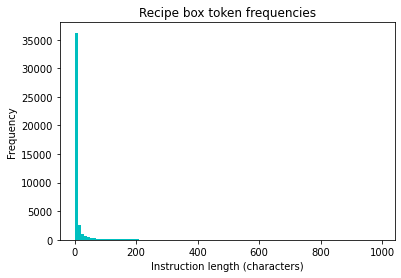

In [ ]:
plt.title("Recipe box token frequencies")
word_counts.plot(kind='hist',
                 bins=np.arange(1, 1000, 10),
                 color='c')
plt.xlabel("Instruction length (characters)")

In [ ]:
def how_many_tokens_with_at_least_freq(num):
    return len([word for word in tokenizer.word_counts.items() if word[1] >= num])

In [ ]:
how_many_tokens_with_at_least_freq(1000000)

3

In [ ]:
np.median([word[1] for word in tokenizer.word_counts.items()])

2.0

In [ ]:
np.max([len(recipe) for recipe in encoded_recipes])

537